In [1]:
import sys
# sys.path.insert(0, '/home/ben.cline/code/jupitercvml_versions/20221117/JupiterCVML/europa/base/src/europa')

In [2]:
import os

# from torchvision.transforms import ColorJitter, ToTensor, Compose
# from dl.augmentations.load_augmentations import TwoVarCompose, ColorJitter
import pandas as pd
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

from dl.dataset.farm_field import DriveableTerrainDataset
from dl.config.label_map_helper import LabelMapHelper
from dl.utils.config import DEFAULT_NORMALIZATION_PARAMS, DEFAULT_WEIGHTED_SAMPLING_PARAMS
from dl.utils.helpers import seed_worker
from dl.utils.losses import get_losses

%matplotlib inline

In [3]:
dataset = 'halo_rgb_stereo_train_v6_1'

In [4]:
data_dir = f'/data2/jupiter/datasets/{dataset}/'
data_dir = f'/mnt/datasets/{dataset}/'
full = pd.read_csv(os.path.join(data_dir, 'master_annotations_10k.csv'), nrows=1000)

In [5]:
full[full.rectified_stereo_output_width == 640]

,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,actor_clothing,actor,annotation_pixelwise_0__cls,annotation_pixelwise_0__id,annotation_pixelwise_0_annotation_job,annotation_pixelwise_0_audit_mistake_found,annotation_pixelwise_0_audit_mistakes,...,rectified_label_save_path,rectified_stereo_output_height,rectified_stereo_output_width,script_id,stereo_left_image,stereo_pipeline_npz_save_path,stereo_right_image,unique_id,is_good_data,ocal_passed
0,90952,12601,151909,bright,NaN,Annotation.PixelAnnotation,653f264fbc832b2eedc635ac,6532962de656d2fc5691ab76,False,[],...,processed/images/651f4ec8ab65fa0a5246bf2a/rect...,512,640,NaN,images/651f4ec8ab65fa0a5246bf2a/artifact_raw_0...,processed/images/651f4ec8ab65fa0a5246bf2a/ster...,images/651f4ec2ab65fa0a5246bf15/artifact_raw_0...,651f4ec8ab65fa0a5246bf2a_T02_T03,True,True
2,56210,20313,77171,NaN,NaN,Annotation.PixelAnnotation,6514ccd405ecc8984884b0e6,6514cca805ecc89848849ee5,False,[],...,processed/images/650bba07ae56212d31aed061/rect...,512,640,NaN,images/650bba07ae56212d31aed061/artifact_raw_0...,processed/images/650bba07ae56212d31aed061/ster...,images/650bba0934fc090aa2481f00/artifact_raw_0...,650bba07ae56212d31aed061_T14_T15,True,True
3,78318,20363,119695,NaN,NaN,Annotation.PixelAnnotation,652a1a9270bc82245b952015,650a4447110d0b8b7fced3f4,False,[],...,processed/images/64e665a008f3ae24fa544be7/rect...,512,640,NaN,images/64e665a008f3ae24fa544be7/artifact_raw_0...,processed/images/64e665a008f3ae24fa544be7/ster...,images/64e6659deef031aa4650a6e9/artifact_raw_0...,64e665a008f3ae24fa544be7_I02_I03,True,True
4,94140,15789,140197,NaN,NaN,Annotation.PixelAnnotation,6531cc2c910822ab0d5a0e7a,6531cc1c910822ab0d5a031f,False,[],...,processed/images/6527c73803ff836473a56f5d/rect...,512,640,NaN,images/6527c73803ff836473a56f5d/artifact_raw_0...,processed/images/6527c73803ff836473a56f5d/ster...,images/6527c73d9c273539da6e67e3/artifact_raw_0...,6527c73803ff836473a56f5d_T10_T11,True,True
6,117753,20848,196139,bright,Matthew Hood,Annotation.PixelAnnotation,655519bac9c928444b8a5b6b,65551993c9c928444b8a4d9b,False,[],...,processed/images/653da674a85ed5097c3bd740/rect...,512,640,NaN,images/653da674a85ed5097c3bd740/artifact_raw_0...,processed/images/653da674a85ed5097c3bd740/ster...,images/653da6774db7d79afd1b30d9/artifact_raw_0...,653da674a85ed5097c3bd740_T14_T15,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982,77434,19479,120265,NaN,NaN,Annotation.PixelAnnotation,652a1e65c4366c0984d7d88f,6508da432c82a89df12beeaa,False,[],...,processed/images/64d4ca7b662f71933a2cd791/rect...,512,640,NaN,images/64d4ca7b662f71933a2cd791/artifact_raw_0...,processed/images/64d4ca7b662f71933a2cd791/ster...,images/64d4ca764210b6d080e0b903/artifact_raw_0...,64d4ca7b662f71933a2cd791_T14_T15,True,True
991,117336,20431,191573,camo,Mason Thomas,Annotation.PixelAnnotation,65550d24fbfc5c128adb844f,65550d20fbfc5c128adb8324,False,[],...,processed/images/653bf07b9c273539da8c5075/rect...,512,640,NaN,images/653bf07b9c273539da8c5075/artifact_raw_0...,processed/images/653bf07b9c273539da8c5075/ster...,images/653bf07462cb552edec7924e/artifact_raw_0...,653bf07b9c273539da8c5075_T14_T15,True,True
992,133154,14468,222668,NaN,NaN,Annotation.PixelAnnotation,655688a95bb0b960d06d96d7,655688a55bb0b960d06d9596,False,[],...,processed/images/6531545f2581dcc8f0dcbed7/rect...,512,640,NaN,images/6531545f2581dcc8f0dcbed7/artifact_raw_0...,processed/images/6531545f2581dcc8f0dcbed7/ster...,images/653154557e0b2f8be1c4a3bf/artifact_raw_0...,6531545f2581dcc8f0dcbed7_T14_T15,True,True
994,50960,15063,100312,NaN,NaN,Annotation.PixelAnnotation,6525d7011c76e1cfe69d8351,6525d6fc1c76e1cfe69d8104,False,[],...,processed/images/65192522dbab2c81d9551a98/rect...,512,640,NaN,images/65192522dbab2c81d9551a98/artifact_raw_0...,processed/images/65192522dbab2c81d9551a98/ster...,images/6519252bb3beb6687423a08f/artifact_raw_0...,65192522dbab2c81d9551a98_T02_T03,True,True


In [6]:
# dataset_df = full[full.rectified_stereo_output_width == 640].head(1).sample(n=100, random_state=1, replace=True)
dataset_df = full[full.rectified_stereo_output_width == 640].sample(n=16, random_state=1, replace=True)


In [7]:
from dl.dataset.datamodes.npz.rectifiedrgb import RectifiedRGBNPZ
import torch
import cv2
batch_size = 8
batch_vals = []
labels = []
b = 0
for i in range(batch_size):
    artifacts = RectifiedRGBNPZ(data_dir, run_productivity_metrics=False).get_artifacts(
        full.iloc[i + batch_size * b])
    batch_vals.append(cv2.resize(artifacts["image"],(1024,512)))
    labels.append(cv2.resize(artifacts["label"],(1024,512), interpolation=cv2.INTER_NEAREST))
batch = torch.Tensor(np.stack(batch_vals)).permute(
    dims=[0, 3, 1, 2]
).to(device='cuda')
labels = torch.tensor(np.stack(labels))[:, None, :, :]
print(batch.shape)
print(batch[0,0,::100,::100])

torch.Size([8, 3, 512, 1024])
tensor([[0.6779, 0.7064, 0.6496, 0.6381, 0.6351, 0.6320, 0.5642, 0.5659, 0.5007,
         0.2832, 0.2863],
        [0.5067, 0.3566, 0.3668, 0.4445, 0.3983, 0.3273, 0.2693, 0.3207, 0.2493,
         0.2074, 0.2367],
        [0.4503, 0.3527, 0.3443, 0.2489, 0.3701, 0.2177, 0.3085, 0.2504, 0.2278,
         0.2030, 0.0868],
        [0.3649, 0.4528, 0.3602, 0.2593, 0.4167, 0.2724, 0.3429, 0.2047, 0.2185,
         0.1150, 0.1277],
        [0.3512, 0.2836, 0.3245, 0.3329, 0.2792, 0.1233, 0.1551, 0.3437, 0.1617,
         0.1658, 0.1076],
        [0.2190, 0.1479, 0.1574, 0.1776, 0.1666, 0.1869, 0.1209, 0.1165, 0.2921,
         0.1287, 0.1781]], device='cuda:0')


In [8]:
import onnx
import onnxruntime

from dl.utils.colors import classlabels_viz_cmap, classlabels_viz_norm


In [9]:
# onnx_path = '/mnt/sandbox1/ben.cline/data/20240110/exports/ds_v6_1_10x_human_hundredth_trees_objects_rev1_full_512_640.onnx'
# onnx_path = '/mnt/sandbox1/ben.cline/data/20240110/exports/ds_v6_2_50k_nextvit_small_sample_2_dynamic_quarter_res_512_640.onnx'
# onnx_path = '/mnt/sandbox1/ben.cline/data/20240110/exports/ds_v6_2_50k_efficientvit_l1_512_quarter_res_dynamic.onnx'
# onnx_path = '/mnt/sandbox1/ben.cline/data/20240110/exports/ds_v6_2_10x_human_hundredth_trees_objects_birds_as_birds_1000x_lower_humans_100x_vehicles_512_640_20240301.onnx'
onnx_path ='/home/alexli/data/M1.5_512.onnx'
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)

In [10]:
ort_session = onnxruntime.InferenceSession(onnx_path, providers=["CPUExecutionProvider"])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(batch)}
ort_outs = ort_session.run(None, ort_inputs)

In [15]:
# if len(ort_outs) == 2:
#     ort_pred_labels = ort_outs[0]
#     ort_confidences = ort_outs[1]
# else:
ort_pred_logits = ort_outs[0]
ort_pred_labels = np.argmax(ort_pred_logits, axis=1)
ort_pred_labels.shape

(8, 256, 512)

# TODO
# COMPARE TORCH AND ONNX RESULTS
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)
https://pytorch.org/tutorials/advanced/super_resolution_with_onnxruntime.html

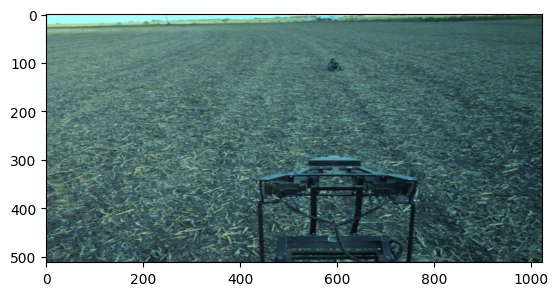

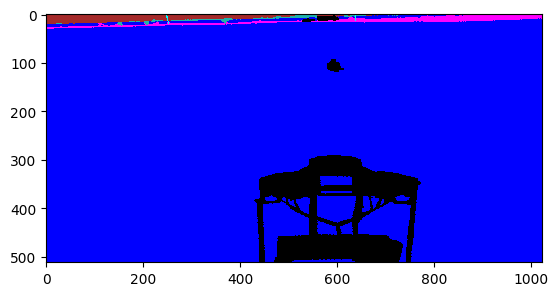

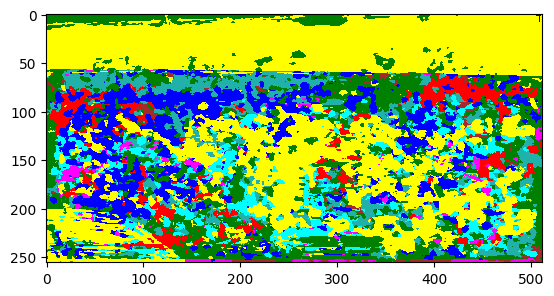

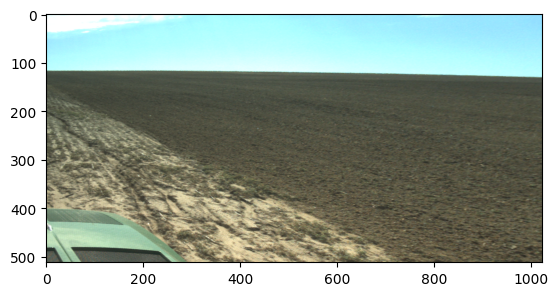

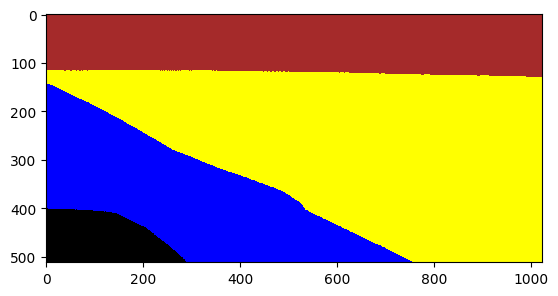

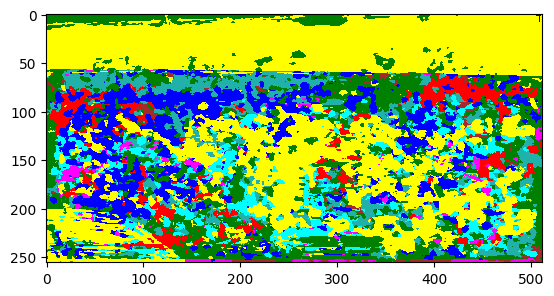

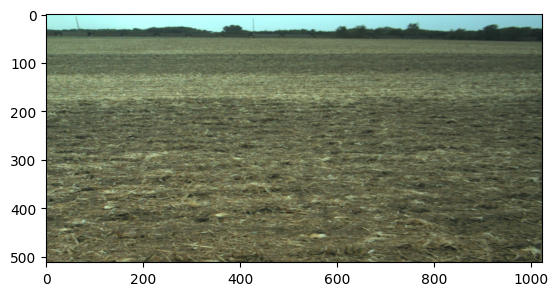

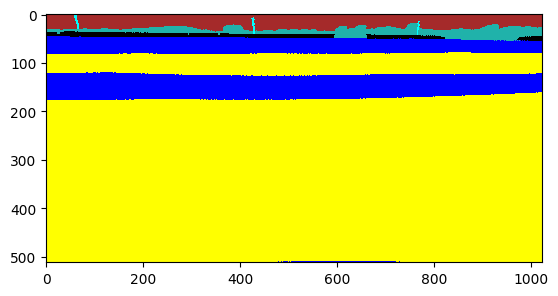

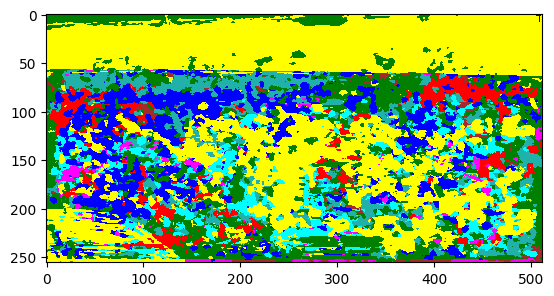

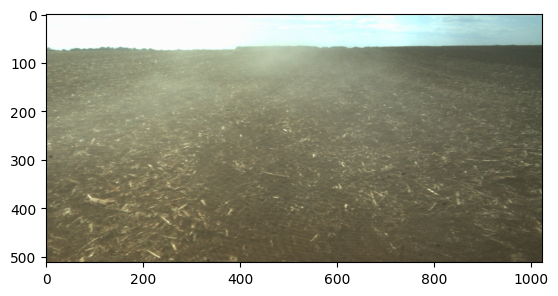

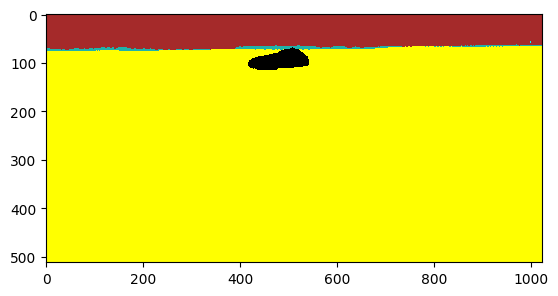

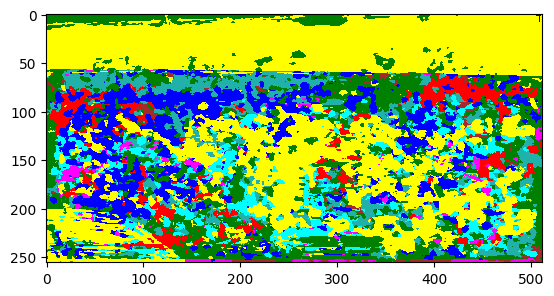

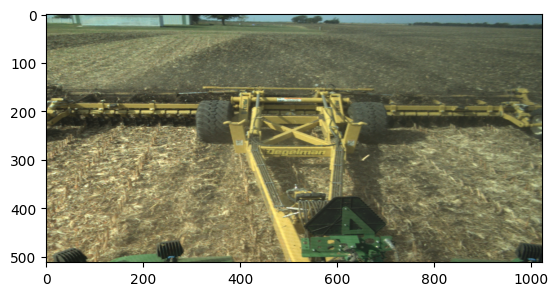

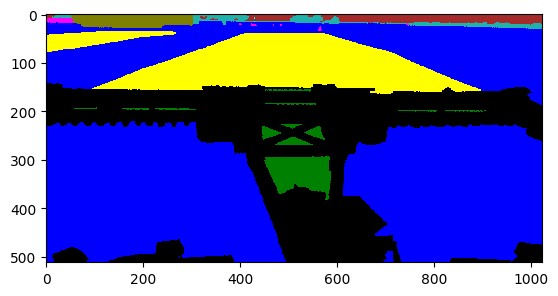

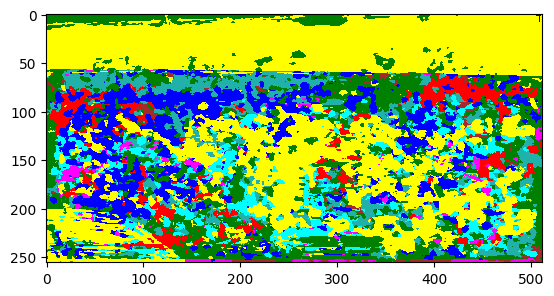

In [18]:
for i in range(5):
    arr = batch[i].cpu().detach().numpy().transpose(1,2,0)
    plt.imshow(arr)
    plt.show()
    label = labels[i][0].detach().numpy()    
    label_to_plot = np.where(label == 255, -1, label)
    fig, ax = plt.subplots()
    plt.imshow(label_to_plot, classlabels_viz_cmap, classlabels_viz_norm, interpolation='nearest')
    plt.show()
    fig, ax = plt.subplots()
    # plt.imshow(ort_pred_labels[i][0], vmin=-1, vmax=9, interpolation='nearest')
    plt.imshow(ort_pred_labels[i], classlabels_viz_cmap, classlabels_viz_norm, interpolation='nearest')
    #plt.imshow(ort_pred_logits[i], classlabels_viz_cmap, classlabels_viz_norm, interpolation='nearest')
    
    

    # plt.imshow(ort_pred_labels[i], classlabels_viz_cmap, classlabels_viz_norm, interpolation='nearest')

    plt.show()
    # plt.imshow(label == 255)
    # plt.colorbar()
    # plt.show()